In [5]:
import pandas as pd
import os

In [6]:
import numpy as np
import seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

sns.set()

# 그래프 기본 설정
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 실제 TTF 파일 경로 (예: 나눔고딕)
font_path = '/content/drive/MyDrive/NanumFontSetup_TTF_ALL/NanumGothic.ttf'

# 폰트 등록 및 적용
font_name = fm.FontProperties(fname=font_path).get_name()
fm.fontManager.addfont(font_path)
mpl.rc('font', family=font_name)

In [14]:
data_root = '/content/drive/MyDrive/data'
months = ['2019-Oct', '2019-Nov', '2019-Dec', '2020-Jan', '2020-Feb', '2020-Mar']

monthly_category_views = {}

for m in months:
    file_path = os.path.join(data_root, f"{m}.parquet")
    print(f"[{m}] 파일 로딩 중...")

    try:
        df = pd.read_parquet(file_path)

        # view 이벤트만 필터링
        df_view = df[df["event_type"] == "view"]

        # 카테고리별 조회 수 집계
        category_counts = df_view["category_lvl1"].value_counts()
        monthly_category_views[m] = category_counts

    except Exception as e:
        print(f"⚠️ {m} 처리 중 오류: {e}")

[2019-Oct] 파일 로딩 중...
[2019-Nov] 파일 로딩 중...
[2019-Dec] 파일 로딩 중...
[2020-Jan] 파일 로딩 중...
[2020-Feb] 파일 로딩 중...
[2020-Mar] 파일 로딩 중...


In [15]:
# 월별 집계 → DataFrame 변환
df_monthly_views = pd.DataFrame(monthly_category_views).fillna(0).astype(int)

In [12]:
df = pd.read_parquet('/content/drive/MyDrive/data/cart_purchase_only.parquet')

 1. df
event_type이 "purchase" 또는 "cart"인 6개월치 이벤트 로그

→ 구매 및 장바구니 행동 분석용

2. df_monthly_views
월별 "view" 이벤트만 추출한 category_lvl1별 조회 수 집계

→ 관심 카테고리, 트렌드 분석용

### 구매 / 장바구니 행동 분석

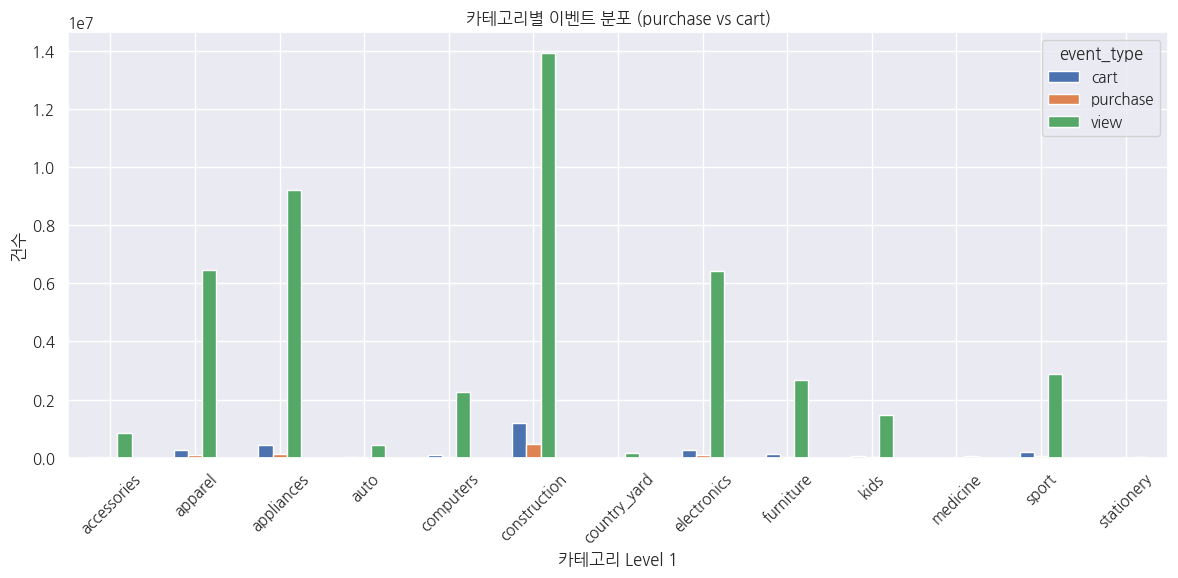

In [18]:
event_counts = df.groupby(['category_lvl1', 'event_type']).size().unstack().fillna(0)

event_counts.plot(kind='bar', figsize=(12, 6))
plt.title("카테고리별 이벤트 분포 (purchase vs cart)")
plt.xlabel("카테고리 Level 1")
plt.ylabel("건수")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


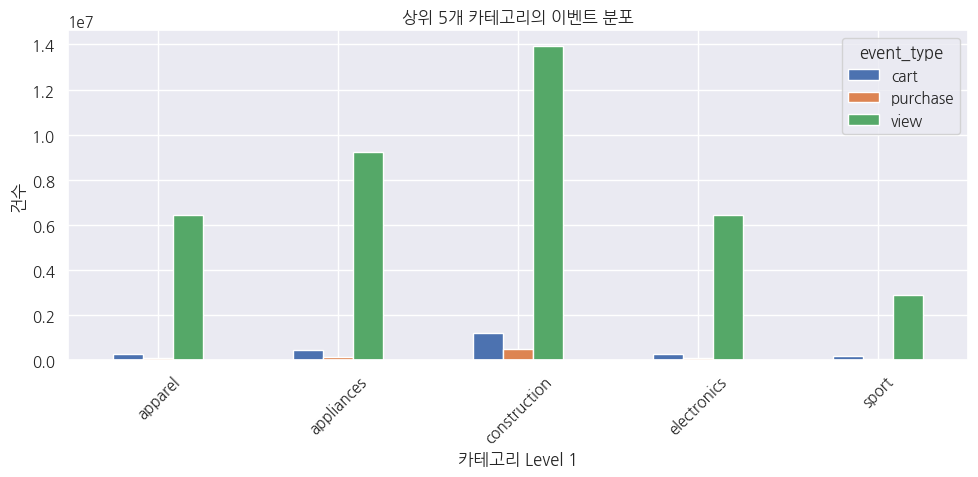

In [20]:
# "purchase" 이벤트 기준으로만 상위 5개 카테고리 선정
top5_by_purchase = df[df["event_type"] == "purchase"]["category_lvl1"].value_counts().nlargest(5).index

# 상위 5개만 필터링
top_event_counts = df[df["category_lvl1"].isin(total_event_counts)] \
    .groupby(['category_lvl1', 'event_type']) \
    .size().unstack().fillna(0)

# 시각화
top_event_counts.plot(kind='bar', figsize=(10, 5))
plt.title("상위 5개 카테고리의 이벤트 분포")
plt.xlabel("카테고리 Level 1")
plt.ylabel("건수")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 카테고리별 퍼널 분석 (조회 → 장바구니 → 구매)

In [21]:
# 1단계: 장바구니(cart)와 구매(purchase) 수 집계 (df)
# 이벤트별 카테고리별 집계
funnel_events = df.groupby(['category_lvl1', 'event_type']).size().unstack().fillna(0)

# 열 이름 맞춰줌
funnel_events = funnel_events.rename(columns={
    "cart": "cart_count",
    "purchase": "purchase_count"
})

In [22]:
# 2단계: 조회(view) 수 추가 (df_monthly_views → 합산)
# 월별 view 수를 카테고리별로 합산
view_total = df_monthly_views.sum(axis=1).rename("view_count")

# 퍼널 데이터와 병합
funnel_df = pd.concat([view_total, funnel_events], axis=1).fillna(0).astype(int)

# 확인
print(funnel_df.head())

               view_count  cart_count  purchase_count     view
category_lvl1                                                 
accessories       4075615       23864            6366   837794
apparel          33522115      271655           82312  6440786
appliances       49863633      430336          142468  9220722
auto              4135966       18510            6662   448558
computers        16582152       83221           29443  2248202


| 흐름                  | 해석                             |
| ------------------- | ------------------------------ |
| View 많고 Cart 적음     | 관심은 많지만 장바구니 진입률 낮음 → 진입 유도 필요 |
| Cart 많고 Purchase 낮음 | 장바구니 이탈률 높음 → 프로모션, UX 개선 필요   |
| Purchase 비율 높음      | 전환율 좋은 카테고리 → 집중 프로모션 가능       |

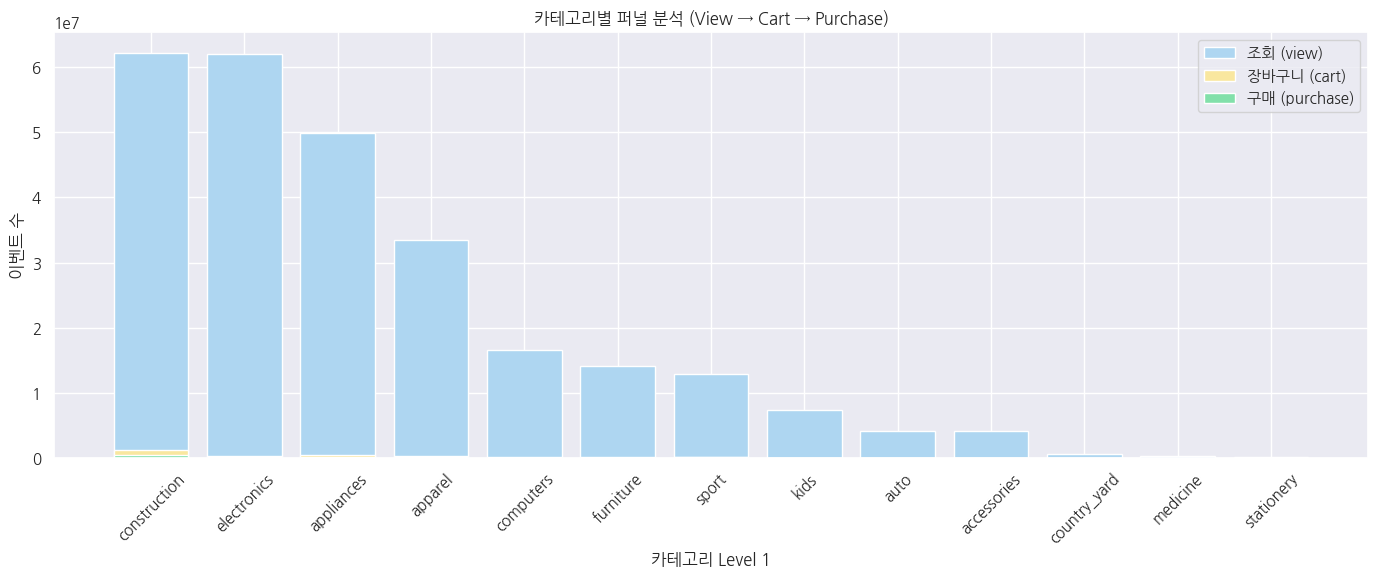

In [23]:
# 3단계: 퍼널 시각화

funnel_df_sorted = funnel_df.sort_values("view_count", ascending=False)

plt.figure(figsize=(14, 6))
x = funnel_df_sorted.index

plt.bar(x, funnel_df_sorted["view_count"], label="조회 (view)", color="#AED6F1")
plt.bar(x, funnel_df_sorted["cart_count"], label="장바구니 (cart)", color="#F9E79F")
plt.bar(x, funnel_df_sorted["purchase_count"], label="구매 (purchase)", color="#82E0AA")

plt.title("카테고리별 퍼널 분석 (View → Cart → Purchase)")
plt.xlabel("카테고리 Level 1")
plt.ylabel("이벤트 수")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### 전환율 확인

In [24]:
# 전환율 보기
funnel_df["view_to_cart"] = (funnel_df["cart_count"] / funnel_df["view_count"]).round(3)
funnel_df["cart_to_purchase"] = (funnel_df["purchase_count"] / funnel_df["cart_count"]).round(3)

print(funnel_df[["view_to_cart", "cart_to_purchase"]].sort_values("cart_to_purchase", ascending=False).head())

               view_to_cart  cart_to_purchase
category_lvl1                                
construction          0.019             0.395
auto                  0.004             0.360
computers             0.005             0.354
electronics           0.004             0.341
appliances            0.009             0.331


In [25]:
funnel_df["view_to_cart"] = (funnel_df["cart_count"] / funnel_df["view_count"]).fillna(0)
funnel_df["cart_to_purchase"] = (funnel_df["purchase_count"] / funnel_df["cart_count"]).fillna(0)

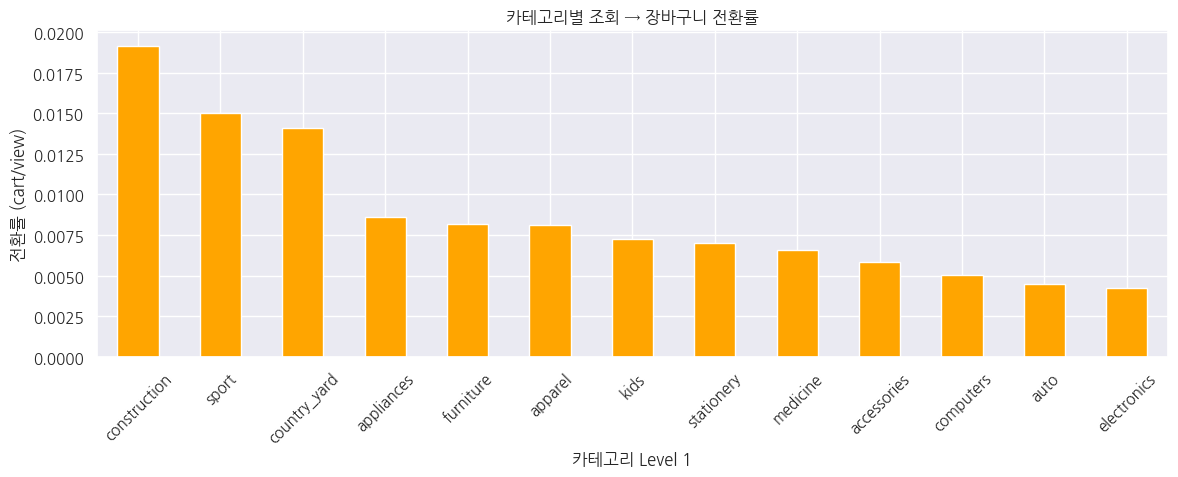

In [26]:
funnel_df.sort_values("view_to_cart", ascending=False)["view_to_cart"].plot(
    kind="bar", figsize=(12,5), color="orange"
)
plt.title("카테고리별 조회 → 장바구니 전환률")
plt.ylabel("전환률 (cart/view)")
plt.xlabel("카테고리 Level 1")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


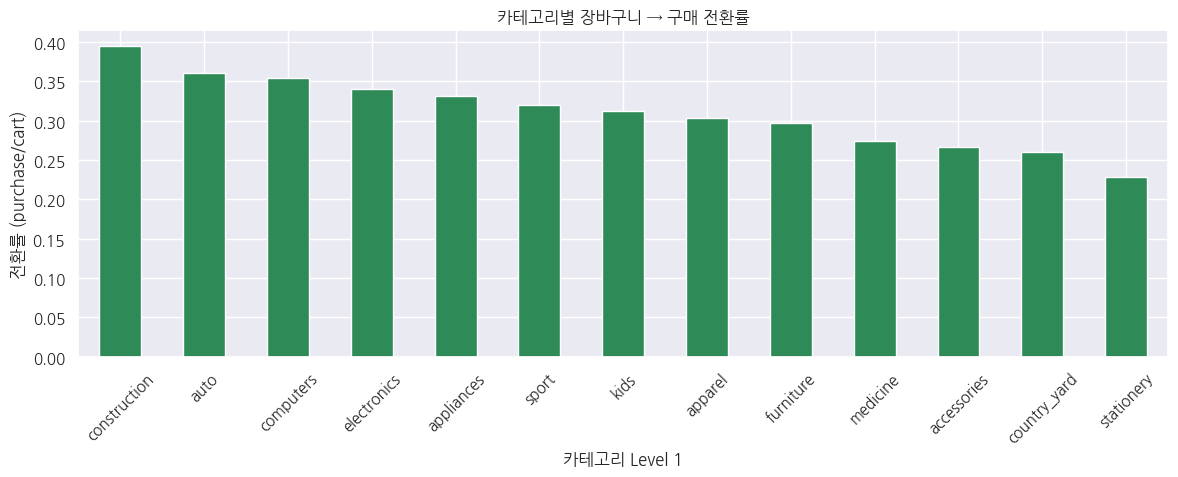

In [27]:
funnel_df.sort_values("cart_to_purchase", ascending=False)["cart_to_purchase"].plot(
    kind="bar", figsize=(12,5), color="seagreen"
)
plt.title("카테고리별 장바구니 → 구매 전환률")
plt.ylabel("전환률 (purchase/cart)")
plt.xlabel("카테고리 Level 1")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 카테고리 Level 2별 평균 가격 비교

In [31]:
# category_lvl2별 평균 가격 및 구매 수
mean_price = df.groupby("category_lvl2")["price"].mean()
purchase_count = df[df["event_type"] == "purchase"].groupby("category_lvl2").size()
lvl2_to_lvl1 = df.groupby("category_lvl2")["category_lvl1"].agg(lambda x: x.mode()[0] if not x.mode().empty else None)

# 통합
price_purchase_df = pd.concat([mean_price, purchase_count.rename("purchase_count"), lvl2_to_lvl1.rename("category_lvl1")], axis=1).fillna(0)

# 정수 처리
price_purchase_df["purchase_count"] = price_purchase_df["purchase_count"].astype(int)

In [34]:
top5_lvl2_per_lvl1 = (
    price_purchase_df
    .sort_values(["category_lvl1", "purchase_count"], ascending=[True, False])
    .groupby("category_lvl1")
    .head(5)
)

top5_lvl2_per_lvl1["label"] = top5_lvl2_per_lvl1["category_lvl1"] + " > " + top5_lvl2_per_lvl1.index

/tmp/ipython-input-36-503196996.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(x_labels, rotation=45, ha="right")


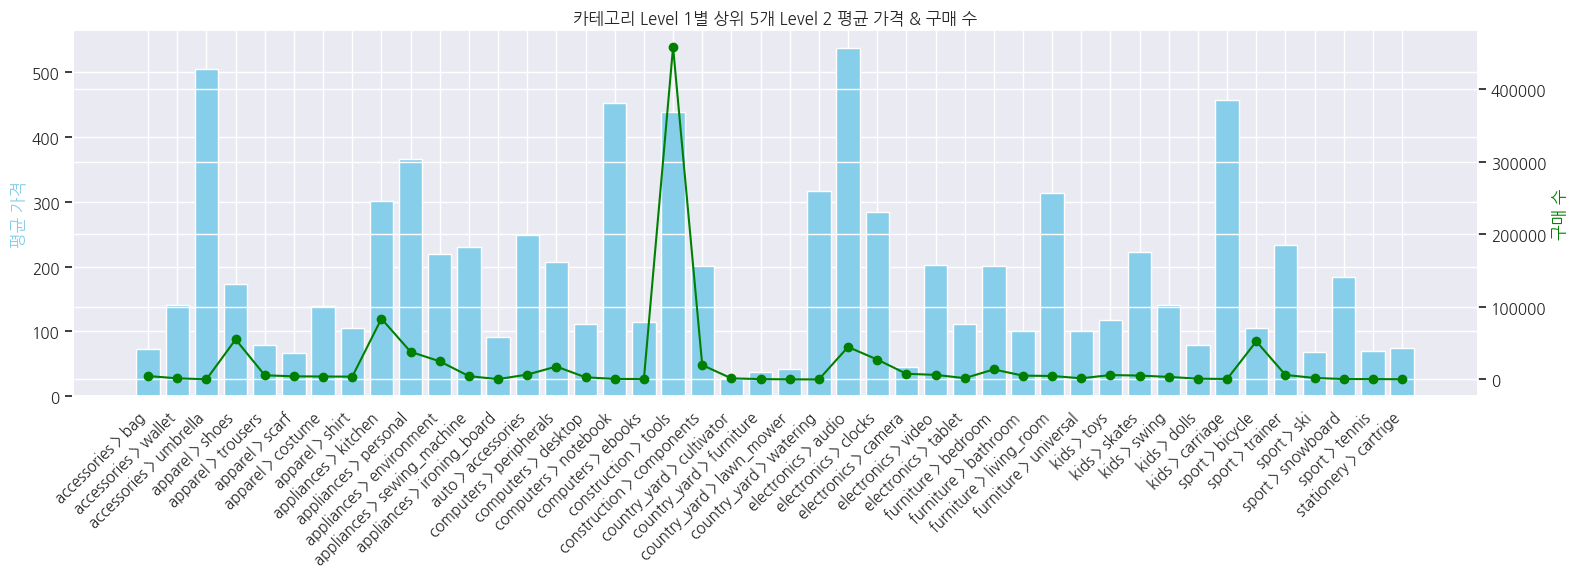

In [36]:
fig, ax1 = plt.subplots(figsize=(16, 6))

x_labels = top5_lvl2_per_lvl1["label"]

# 막대그래프
ax1.bar(x_labels, top5_lvl2_per_lvl1["price"], color="skyblue", label="평균 가격")
ax1.set_ylabel("평균 가격", color="skyblue")
ax1.set_xticklabels(x_labels, rotation=45, ha="right")

# 선 그래프
ax2 = ax1.twinx()
ax2.plot(x_labels, top5_lvl2_per_lvl1["purchase_count"], color="green", marker='o', label="구매 수")
ax2.set_ylabel("구매 수", color="green")

plt.title("카테고리 Level 1별 상위 5개 Level 2 평균 가격 & 구매 수")
fig.tight_layout()
plt.show()

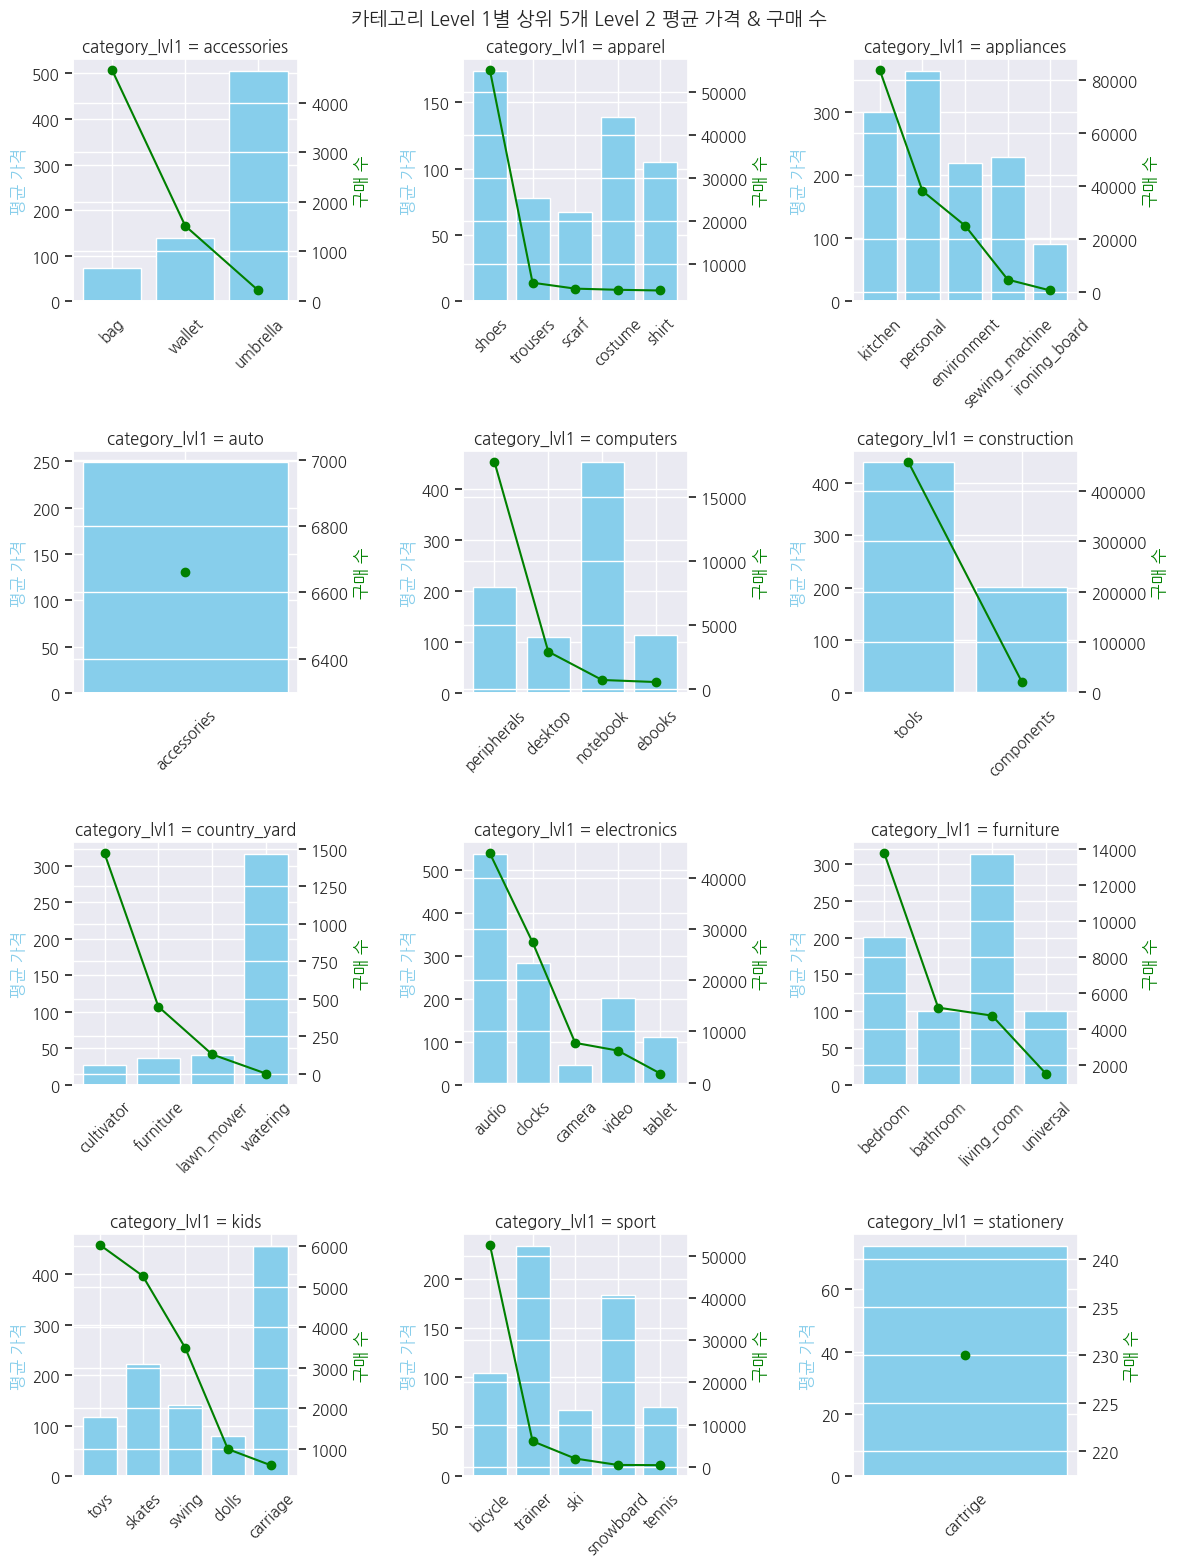

In [49]:
# FacetGrid 시각화를 위한 데이터 준비
plot_df = top5_lvl2_per_lvl1.copy()
plot_df["category_lvl2"] = plot_df.index  # index 복원

# 각 카테고리 레벨1별로 평균 가격 & 구매 수 그리기 (막대 + 선)
g = sns.FacetGrid(plot_df, col="category_lvl1", col_wrap=3, height=4, sharex=False, sharey=False)

def dual_axis_bar_line(data, color, **kwargs):
    ax = plt.gca()
    ax2 = ax.twinx()

    # 막대그래프: 평균 가격
    ax.bar(data["category_lvl2"], data["price"], color="skyblue", label="평균 가격")
    ax.set_ylabel("평균 가격", color="skyblue")
    ax.tick_params(axis='x', rotation=45)

    # 선그래프: 구매 수
    ax2.plot(data["category_lvl2"], data["purchase_count"], color="green", marker='o', label="구매 수")
    ax2.set_ylabel("구매 수", color="green")

g.map_dataframe(dual_axis_bar_line)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("카테고리 Level 1별 상위 5개 Level 2 평균 가격 & 구매 수", fontsize=14)
plt.tight_layout()
plt.show()

In [51]:
# 인덱스 복원 (category_lvl2가 인덱스일 경우)
top5_lvl2_per_lvl1 = top5_lvl2_per_lvl1.reset_index()

# 카테고리 lvl1별 category_lvl2 종류 수 확인
lvl2_counts = top5_lvl2_per_lvl1.groupby("category_lvl1")["category_lvl2"].nunique().reset_index()
lvl2_counts.columns = ["category_lvl1", "num_of_lvl2"]

# 5개 미만인 카테고리 확인
few_categories = lvl2_counts[lvl2_counts["num_of_lvl2"] < 5]
print("⚠️ Level 2가 5개 미만인 Level 1 카테고리들:")
print(few_categories)

⚠️ Level 2가 5개 미만인 Level 1 카테고리들:
   category_lvl1  num_of_lvl2
0    accessories            3
3           auto            1
4      computers            4
5   construction            2
6   country_yard            4
8      furniture            4
11    stationery            1


In [45]:
# 1. 인덱스 문제 방지
price_purchase_df = price_purchase_df.reset_index(drop=True)

# 2. 정렬
price_purchase_df_sorted = price_purchase_df.sort_values(
    by=["category_lvl1", "purchase_count"],
    ascending=[True, False]
)

# 3. 그룹별 출력
grouped = price_purchase_df_sorted.groupby("category_lvl1")

for lvl1, group in grouped:
    print(f"\n📂 {lvl1}")
    display(group[["category_lvl2", "price", "purchase_count"]])



📂 accessories


,category_lvl2,price,purchase_count
2,bag,72.869629,4653
59,wallet,140.223720,1509
55,umbrella,505.455536,204



📂 apparel


,category_lvl2,price,purchase_count
38,shoes,173.469817,55118
53,trousers,78.162966,5654
35,scarf,67.123630,4275
12,costume,138.563682,4006
37,shirt,105.029116,3844
39,shorts,566.916863,3618
56,underwear,252.186683,2634
54,tshirt,138.103821,1296
26,jeans,101.225294,552
45,sock,96.947409,358



📂 appliances


,category_lvl2,price,purchase_count
28,kitchen,300.417508,83764
34,personal,365.738355,38076
19,environment,219.617842,24939
36,sewing_machine,229.856038,4510
24,ironing_board,91.129814,391
23,iron,105.189985,8



📂 auto


,category_lvl2,price,purchase_count
0,accessories,248.921774,6662



📂 computers


,category_lvl2,price,purchase_count
33,peripherals,207.232636,17732
14,desktop,110.540183,2899
31,notebook,452.043533,682
18,ebooks,114.100546,521



📂 construction


,category_lvl2,price,purchase_count
50,tools,438.182716,458585
11,components,201.406128,19799



📂 country_yard


,category_lvl2,price,purchase_count
13,cultivator,27.519242,1470
21,furniture,37.117533,447
29,lawn_mower,40.974491,128
60,watering,316.510000,0



📂 electronics


,category_lvl2,price,purchase_count
1,audio,537.784946,44744
10,clocks,283.537465,27411
7,camera,45.423735,7765
58,video,201.948152,6262
47,tablet,111.050102,1768
48,telephone,207.040177,750
43,smartphone,316.743477,301



📂 furniture


,category_lvl2,price,purchase_count
4,bedroom,201.361000,13747
3,bathroom,100.289018,5182
30,living_room,313.976273,4738
57,universal,100.721108,1517



📂 kids


,category_lvl2,price,purchase_count
51,toys,117.343520,6032
40,skates,222.277282,5272
46,swing,141.080415,3492
16,dolls,78.511664,998
8,carriage,456.516635,602
20,fmcg,81.807219,143



📂 sport


,category_lvl2,price,purchase_count
6,bicycle,104.726984,52482
52,trainer,233.533905,6121
41,ski,67.286982,2023
44,snowboard,183.425409,510
49,tennis,69.614793,461
15,diving,306.894743,27



📂 stationery


,category_lvl2,price,purchase_count
9,cartrige,74.130322,230


In [48]:
# 1. 인덱스에 category_lvl2가 있다면 복원
if "category_lvl2" not in price_purchase_df.columns:
    price_purchase_df = price_purchase_df.reset_index()

# 2. 정렬: 대분류 > 구매 수 내림차순
price_purchase_df_sorted = price_purchase_df.sort_values(
    by=["category_lvl1", "purchase_count"],
    ascending=[True, False]
)

# 3. 보기 좋게 출력 옵션
import pandas as pd
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", None)

# 4. 출력
print(price_purchase_df_sorted[["category_lvl1", "category_lvl2", "price", "purchase_count"]])


   category_lvl1   category_lvl2       price  purchase_count
2    accessories             bag   72.869629            4653
59   accessories          wallet  140.223720            1509
55   accessories        umbrella  505.455536             204
38       apparel           shoes  173.469817           55118
53       apparel        trousers   78.162966            5654
35       apparel           scarf   67.123630            4275
12       apparel         costume  138.563682            4006
37       apparel           shirt  105.029116            3844
39       apparel          shorts  566.916863            3618
56       apparel       underwear  252.186683            2634
54       apparel          tshirt  138.103821            1296
26       apparel           jeans  101.225294             552
45       apparel            sock   96.947409             358
32       apparel         pajamas  109.946339             352
22       apparel           glove   72.605585             310
27       apparel        

# 전략 요약
| 분석 기법          | 현재 분석 연결                       | 마케팅 활용                   |
| -------------- | ------------------------------ | ------------------------ |
| AARRR          | 퍼널 데이터 기반                      | 전환율 진단, UI 개선, 마케팅 타겟 설정 |
| 코호트 분석         | 유저별 첫 방문 시점                    | 장기 유지율, 고객 생애가치, 이탈 예측   |
| 퍼널 분석          | view → cart → purchase         | 카테고리/브랜드/가격별 개선 포인트      |
| 세그먼트 분석        | 유저 행동 기반 클러스터링                 | 리마케팅, 타겟 세분화             |
| RFM 분석 (추가 가능) | Recency / Frequency / Monetary | 충성 유저 식별, CRM 전략         |

# RFM 분석과 연결하기
- 고객을 세 가지 지표로 나누어 충성도 기반 세그먼트를 파악하는 대표적인 마케팅 기법

| 항목                | 의미                  | 계산 기준         |
| ----------------- | ------------------- | ------------- |
| **Recency (R)**   | 마지막 구매일로부터 얼마나 지났는가 | 최근일 - 마지막 구매일 |
| **Frequency (F)** | 얼마나 자주 구매했는가        | 구매 횟수         |
| **Monetary (M)**  | 얼마나 많이 썼는가          | 총 지출 금액       |



In [57]:
# 1. 구매 데이터만 필터링
df_purchase = df[df["event_type"] == "purchase"].copy()

# 2. 날짜 정리
df_purchase["event_time"] = pd.to_datetime(df_purchase["event_time"]).dt.tz_localize(None)

# 3. 기준일 설정 (예: 가장 마지막 데이터 기준)
snapshot_date = df_purchase["event_time"].max() + pd.Timedelta(days=1)

# 4. RFM 계산
rfm = df_purchase.groupby("user_id").agg({
    "event_time": lambda x: (snapshot_date - x.max()).days,   # Recency
    "user_id": "count",                                       # Frequency
    "price": "sum"                                            # Monetary
})

rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm = rfm.reset_index()
rfm

,user_id,Recency,Frequency,Monetary
0,128029678,12,1,181.73
1,128968633,25,1,355.22
2,192078182,21,1,110.72
3,229414998,10,1,450.20
4,237973968,14,2,589.18
...,...,...,...,...
453482,635148377,1,2,709.65
453483,635148505,1,1,167.29
453484,635153043,1,1,763.21
453485,635158569,1,4,1777.66


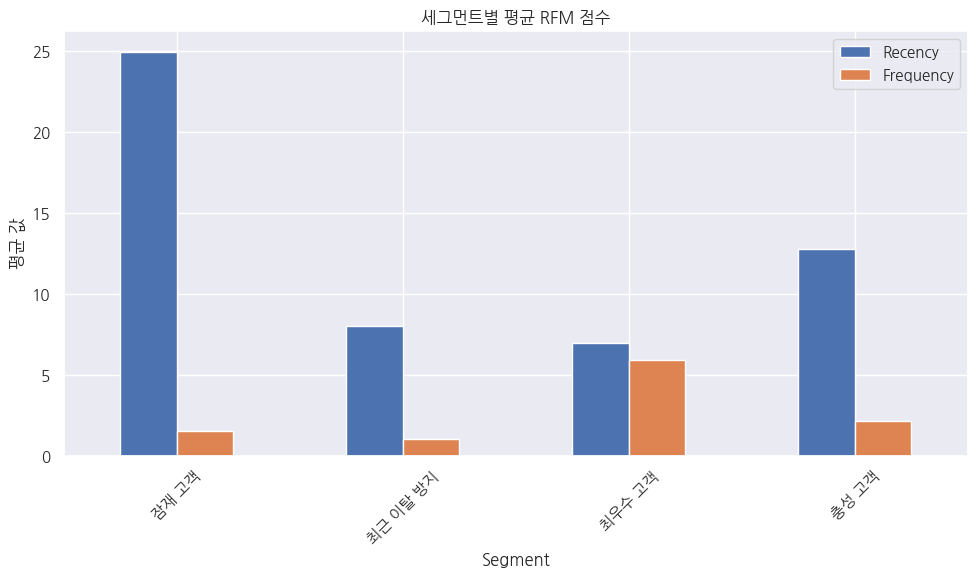

In [65]:
# 세그먼트별 R, F, M 평균값 비교
rfm_avg = rfm.groupby("Segment")[["Recency", "Frequency", "Monetary"]].mean()

rfm_avg.plot(kind="bar", figsize=(10, 6))
plt.title("세그먼트별 평균 RFM 점수")
plt.ylabel("평균 값")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [58]:
# 1이 가장 최근/빈번/고액
rfm["R_score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1])
rfm["F_score"] = pd.qcut(rfm["Frequency"].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm["M_score"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5])

# 최종 RFM 스코어 조합
rfm["RFM_Score"] = rfm["R_score"].astype(str) + rfm["F_score"].astype(str) + rfm["M_score"].astype(str)

In [59]:
def segment(r, f, m):
    if r >= 4 and f >= 4 and m >= 4:
        return "최우수 고객"
    elif r >= 3 and f >= 3:
        return "충성 고객"
    elif r >= 4:
        return "최근 이탈 방지"
    else:
        return "잠재 고객"

rfm["Segment"] = rfm[["R_score", "F_score", "M_score"]].astype(int).apply(lambda x: segment(*x), axis=1)


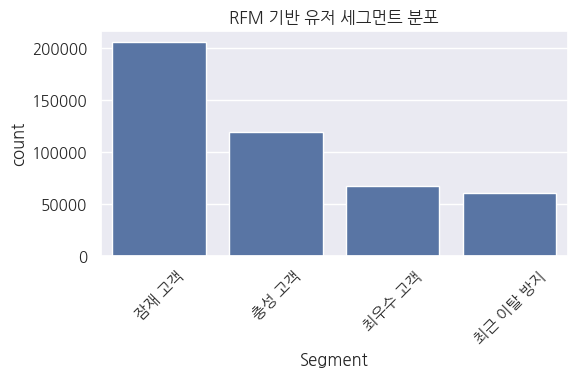

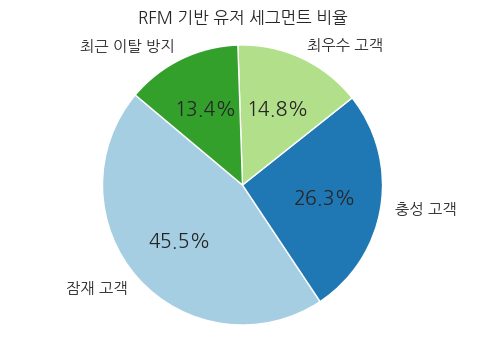

In [63]:
plt.figure(figsize=(6,4))
sns.countplot(data=rfm, x="Segment", order=rfm["Segment"].value_counts().index)
plt.title("RFM 기반 유저 세그먼트 분포")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

rfm_seg_counts = rfm["Segment"].value_counts()

plt.figure(figsize=(6, 4))
plt.pie(
    rfm_seg_counts,
    labels=rfm_seg_counts.index,
    autopct="%.1f%%",
    startangle=140,
    colors=plt.cm.Paired.colors
)
plt.title("RFM 기반 유저 세그먼트 비율")
plt.axis("equal")
plt.show()

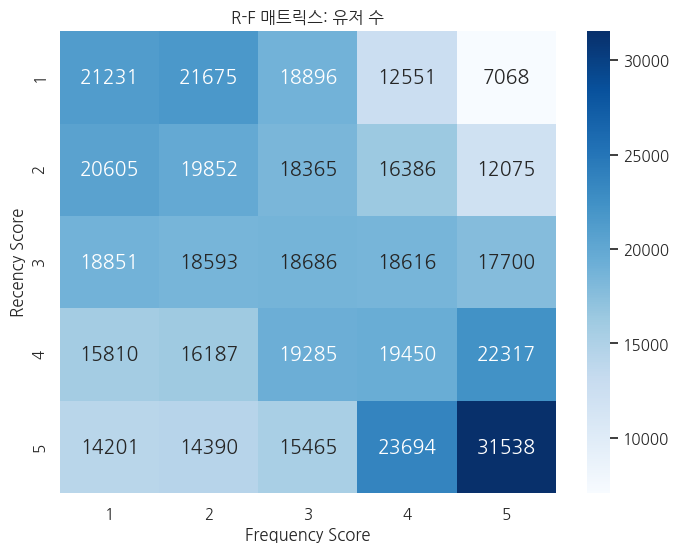

In [66]:
# R, F 점수를 기준으로 1~5로 나눈 다음 교차표 생성
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=range(5, 0, -1)).astype(int)
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=range(1, 6)).astype(int)

rf_matrix = rfm.pivot_table(index="R_Score", columns="F_Score", values="user_id", aggfunc="count")

plt.figure(figsize=(8, 6))
sns.heatmap(rf_matrix, annot=True, fmt=".0f", cmap="Blues")
plt.title("R-F 매트릭스: 유저 수")
plt.xlabel("Frequency Score")
plt.ylabel("Recency Score")
plt.show()


- 오른쪽 아래 (R=5, F=5):

31538명 → 최근에 방문했고, 매우 자주 방문하는 핵심 VIP 고객

가장 가치 있는 고객층으로 집중적인 리텐션 전략 필요

- 왼쪽 위 (R=1, F=1):

21231명 → 오래전에 한번 방문했던 고객

이탈한 유저일 확률 높음 → 재활성화 캠페인 필요

- 중앙 (R=3, F=3):

18686명 → 활동은 하나 최근성도 빈도도 중간

성장 가능 고객군, 지속적인 케어 필요

--> 고객 세그먼트 기반 타겟 마케팅이나 CRM 전략 수립에 매우 유용


| 영역         | 전략 제안                                                        |
|--------------|------------------------------------------------------------------|
| Retention    | (R=4-5, F=1-2) 최근에 한 번만 온 고객 → 다시 방문 유도 (알림, 쿠폰) |
| Revenue      | (R=4-5, F=4-5) VIP 고객 → 업셀링, 멤버십 유도                     |
| Reactivation | (R=1-2, F=3-5) 자주 왔지만 최근에 안 온 고객 → 리마인더, 타겟 메일   |
| Referral     | (R=5, F=5) 추천 유도, 리뷰 요청                                  |
